In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
tsla_df = pd.read_pickle('data/stock_price_TSLA.pkl')
spy_df = pd.read_pickle('data/stock_price_SPY.pkl')

In [ ]:
tsla_return = tsla_df['close'] / tsla_df['close'].shift(1) - 1
spy_return = spy_df['close'] / spy_df['close'].shift(1) - 1

In [ ]:
tsla_return.head()

In [5]:
tsla_return = tsla_return.rename('tsla_return').to_frame()
spy_return = spy_return.rename('spy_return').to_frame()

In [6]:
combined_returns = tsla_return.merge(spy_return,
                                     how='inner',
                                     left_index=True,
                                     right_index=True)

In [7]:
combined_returns.index = pd.to_datetime(combined_returns.index)

In [8]:
def get_signal(return_value):
    if return_value < 0:
        return -1
    else:
        return 1

In [9]:
combined_returns['signal'] = combined_returns['tsla_return'].apply(get_signal)

In [10]:
combined_returns = combined_returns.shift(-1)

In [11]:
# combined_returns['2019':].plot()

In [12]:
tweet_df = pd.read_pickle('temp_data/top_user_tweets_with_sentiment.pkl')

In [13]:
tweet_df.shape

(675727, 15)

In [14]:
def get_sentiment_discrete(sentiment_raw):
    if sentiment_raw < -0.1:
        return -1
    elif sentiment_raw < 0.1:
        return 0
    else:
        return 1

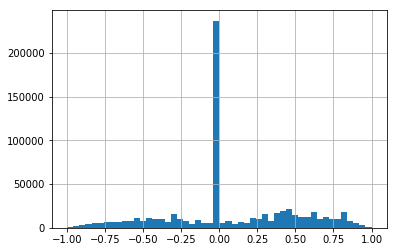

In [15]:
tweet_df['sentiment'].hist(bins=50)

In [16]:
tweet_df['sentiment_discrete'] = tweet_df['sentiment'].apply(get_sentiment_discrete)

In [17]:
tweet_df['date'] = pd.to_datetime(tweet_df['UTC_date']).dt.normalize()

In [18]:
tweet_df['temp_date'] = tweet_df['date']

In [19]:
tweet_df_modified = tweet_df.set_index('date').sort_index().copy()

In [20]:
tweet_df_modified = tweet_df_modified[['temp_date', 'text', 'sentiment', 'sentiment_discrete', 'username', 'author_id']]

In [21]:
tweet_df_modified = tweet_df_modified[tweet_df_modified['sentiment_discrete'] != 0].copy()

In [26]:
tweet_df_modified.shape

(418445, 6)

In [22]:
all_df = tweet_df_modified.merge(combined_returns, 
                                 how='inner',
                                 left_index=True, 
                                 right_index=True)

In [23]:
all_df.head()

,temp_date,text,sentiment,sentiment_discrete,username,author_id,tsla_return,spy_return,signal
date,,,,,,,,,
2018-01-02,2018-01-02,made big profits in $tsla 315c weeklies today....,0.6486,1,option_snipper,2806294664,-0.010233,0.006325,-1.0
2018-01-02,2018-01-02,"If $AAPL buys $TSLA, Hell will freeze over and...",-0.6597,-1,MrShortSqueeze,760558055629197313,-0.010233,0.006325,-1.0
2018-01-02,2018-01-02,Tesla is rising despite slashed Model 3 delive...,0.1695,1,MktsInsider,778670441405775872,-0.010233,0.006325,-1.0
2018-01-02,2018-01-02,http://goo.gl/Na4qAQ <-- Tim Sykes made a nice...,0.7840,1,SmallCaps33,2852147156,-0.010233,0.006325,-1.0
2018-01-02,2018-01-02,The reverse trade going on as tech is soaring ...,0.9011,1,GerberKawasaki,349249475,-0.010233,0.006325,-1.0


In [24]:
tweet_df_modified.shape, combined_returns.shape, all_df.shape

((418445, 6), (2233, 3), (340917, 9))

In [27]:
all_df = all_df.dropna(subset=['sentiment_discrete', 'signal'])

In [28]:
all_df['sentiment_discrete'] = all_df['sentiment_discrete'].astype(int)
all_df['signal'] = all_df['signal'].astype(int)

In [29]:
accuracy_score(all_df['signal'], all_df['sentiment_discrete'])

0.4916834840524114

In [30]:
all_df.shape

(339926, 9)

In [62]:
def temp_precision(df):
    denom = (df['sentiment_discrete'] == -1).sum()
    num = ((df['sentiment_discrete'] == -1) & (df['signal'] == -1)).sum()
    
    if denom == 0:
        return None
    else:
        return num / denom

In [63]:
# acc_temp = all_df.groupby('username').apply(lambda r: accuracy_score(r['signal'], r['sentiment_discrete']) )
acc_temp = all_df.groupby('username').apply(lambda d: temp_precision(d) )

In [64]:
count_temp = all_df.groupby('username').agg({
    'text': 'size',
    'temp_date': lambda x: len(x.unique()),
    'sentiment_discrete': lambda x: (x == -1).sum()
})

In [65]:
summary_df = count_temp.merge(acc_temp.to_frame(), left_index=True, right_index=True).reset_index()

In [68]:
summary_df.head()

,username,text,temp_date,sentiment_discrete,0
0,007stockchat,8,7,0,NaN
1,0rangeCru5h,224,111,91,0.571429
2,10Bagstocks,14,14,3,0.666667
3,10minutetrading,60,48,19,0.368421
4,1101100100,42,21,16,0.625000


In [69]:
summary_df.columns = ['username', 'count', 'n_uniq_dates', 'count_neg_preds', 'accuracy']

In [70]:
# summary_df = pd.DataFrame(dict(acc=acc_temp, count=count_temp)).reset_index()

In [71]:
mask = (summary_df['count_neg_preds'] > 30) & (summary_df['n_uniq_dates'] > 30)

In [72]:
summary_df[mask].sort_values('accuracy', ascending=False).head(10)

,username,count,n_uniq_dates,count_neg_preds,accuracy
3298,Wise_Owl_Trader,158,34,69,0.811594
285,AtlasAlphaTrade,103,45,41,0.780488
5268,soclose2me,210,48,80,0.775000
782,DavidRo19158533,799,47,330,0.769697
1577,KennethMilesTa2,119,42,58,0.758621
3965,edelagrave,74,53,47,0.744681
3860,davidtayar5,122,71,48,0.729167
1736,MDTrades12,87,40,33,0.727273
3557,bbolan1,130,65,47,0.723404
4572,liamdenning,88,46,47,0.723404


In [74]:
tweet_df_modified[tweet_df_modified['username'] == 'soclose2me'][['text', 'sentiment']].values

array([["Seem to be forgetting/ignoring production of model 3 doubled since last shutdown (6 weeks ago) to 3.5k/wk now and BMW can't give their piece of crap away ($56/month lease) while 500k stand in line to buy $TSLA at full price.",
        -0.3818],
       ["I think they are knee-jerk pissed because Elon put a stick in wall street's eye on the call. But are wary given he ramped the shit out of production and is laser focused on profitability. $TSLA #Tesla",
        0.8735],
       ["@MarinKatusa @ttmygh Lil dated but have you seen Marin's prezy on renewable energy? Time shifting power is the next challenge.. $tsla $notjustacarcompany https://www.youtube.com/watch?v=l0cF2JYZ8Tg …",
        0.4606],
       ['For how long? 4-5 days? So what? And everyone keeps throwing around this 45k per car number. That was price with capex amortized at <1800/w. Was not COGS. CAPEX is being amortized faster than ever as production rate increases and line runs longer. $tsla $tslaq',
        0.533],
 